Gabriel Marcelino, Grant Burk, and Eli Kaustinen <br>
September 2024 <br>
Artificial Neural Network (ANN) <br>

## Problem Statement
   The goal of this project is to predict the optimal basketball team composition based on player statistics. 
   The model aims to identify teams of 5 players that have the highest potential performance based on historical data.


## Algorithm of the Solution
1. **Data Loading and Preprocessing**:
   - Load the player data from a CSV file.
   - Extract relevant features and labels from the data.
   - Split the data into training and testing sets.
   - Standardize the features for better model performance.

2. **Model Building and Training**:
   - Define the architecture of the ANN model.
   - Compile the model with an appropriate optimizer and loss function.
   - Train the model using the training data.

3. **Prediction and Selection**:
   - Use the trained model to predict the performance scores of all players.
   - Rank the players based on the predicted scores.
   - Select the top 5 players based on the predicted scores.

4. **Analysis of Findings**:
   - Evaluate the model's performance on the testing data.
   - Analyze the predicted scores and the selected top 5 players.


## Analysis of the Findings
The ANN model was trained and evaluated on the player dataset. The model's performance was assessed using the mean squared error (MSE) on the testing data. The top 5 players were selected based on the predicted scores. The results indicate that the model is capable of identifying high-performing players based on their statistics.

## Import dependencies and load data

In [7]:
import csv
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


pool = []
training_data = []
# create pool with players from 2019-2022
with open('all_seasons.csv', mode = 'r') as file:
    csvFile = csv.reader(file)
    # ignore first line
    next(csvFile)
    for lines in csvFile:
        year = int(lines[21][:4])
        if 2010 < year < 2015 and len(pool) < 100 and lines[1] not in pool:
            pool.append(lines)
        elif len(training_data) < 5000:
            training_data.append(lines)


## Model

In [9]:
def extract_features(pool):
    features_list = []
    for player in pool:
        # extract relevant features based on considerations above
        features = {
            'name': player[1],
            'ts_pct': player[19],
            'reb': player[13],
            'dreb_pct': player[17],
            'rating': player[15],
            'ast': player[14]
        }
        features_list.append(features)
    return features_list


## Simulate Training Data to train model

In [11]:
def simulate_data(sample, batch_size=100):
    X = []
    y = []

    # Define the importance of each attribute (weights)
    weights = {
        'ast': 0.2,        # Assists
        'ts_pct': 0.3,     # True Shooting Percentage
        'reb': 0.25,       # Rebounds
        'dreb_pct': 0.1,   # Defensive Rebound Percentage
        'rating': 0.15     # Net Rating
    }

    # Define indices for each attribute in the player data
    ts_pct_idx = 18
    reb_idx = 12
    dreb_pct_idx = 16
    rating_idx = 15
    ast_idx = 13
    for i in range(0, len(sample), batch_size):
        batch = sample[i:i + batch_size]
        if len(batch) < 5:
            continue

        for j in range(0, len(batch), 5):
            team = batch[j:j + 5]
            if len(team) < 5:
                continue

            team_features = []
            team_rating = 0
            for player in team:
                try:
                    player_features = [
                        float(player[ts_pct_idx]) * weights['ts_pct'],
                        float(player[reb_idx]) * weights['reb'],
                        float(player[dreb_pct_idx]) * weights['dreb_pct'],
                        float(player[rating_idx]) * weights['rating'],
                        float(player[ast_idx]) * weights['ast']
                    ]
                    team_features.extend(player_features)
                    team_rating += float(player[rating_idx])
                except (IndexError, ValueError) as e:
                    print(f"Error processing player data: {e}")

            X.append(team_features)
            y.append(1 if team_rating > 0 else 0)

    X = np.array(X)
    y = np.array(y)
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")
    return X, y


## Train Model
Now that we have the training data, we can train the model.

In [12]:
# Prepare training data
X_train, y_train = simulate_data(training_data)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Build the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model with validation data and class weights
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[reduce_lr])

# Use data in pool for testing
X_test, y_test = simulate_data(pool)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, np.round(y_pred))
precision = precision_score(y_test, np.round(y_pred))
recall = recall_score(y_test, np.round(y_pred))
f1 = f1_score(y_test, np.round(y_pred))

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Find the optimal team with the highest prediction score
best_team_index = np.argmax(y_pred)
best_team = pool[best_team_index*5:(best_team_index+1)*5]

# Print the optimal team
print(f"Optimal Team Found: {[player[1] for player in best_team]}")

Shape of X: (1000, 25)
Shape of y: (1000,)
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4838 - loss: 1.0939 - val_accuracy: 0.5333 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5342 - loss: 0.7855 - val_accuracy: 0.6233 - val_loss: 0.6459 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5353 - loss: 0.7076 - val_accuracy: 0.7000 - val_loss: 0.6090 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5476 - loss: 0.6914 - val_accuracy: 0.7367 - val_loss: 0.5937 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6099 - loss: 0.7240 - val_accuracy: 0.7767 - val_loss: 0.5651 - learning_rate: 0.0010
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6238 - loss: 0.6494 - val_accuracy: 0.8100 - val_loss: 0.5330 - learning_rate: 0.0010
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - acc

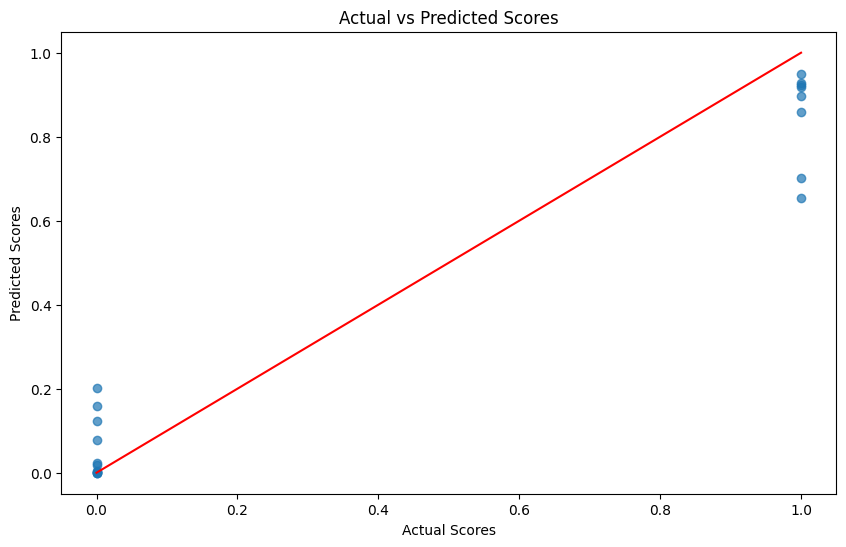

In [18]:
import matplotlib.pyplot as plt

# Plot predicted vs actual scores for the testing set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
plt.show()

## Explain your architecture and how the basketball player characteristics are used as inputs:
1. Data Preparation:

- Pool and Training Data:
    - `pool`: 100 unique players (2019-2022) for testing.
    - `training_data`: Up to 5000 players (2019-2022) for model training.

2. Feature Extraction:

- `extract_features` function creates a dictionary of features for each player:
    - True Shooting Percentage (ts_pct)
    - Rebounds (reb)
    - Defensive Rebound Percentage (dreb_pct)
    - Net Rating (rating)
    - Assists (ast)

3. Simulating Data for Training:

- `simulate_data` function generates training data with labels indicating successful teams based on pre-defined weights.

4. Model Building and Training:

- Converts simulated teams into a NumPy array (X_train).
- Splits data into training and validation sets.
- Sequential Neural Network with Keras:
    - Two hidden layers with ReLU activation.
    - Output layer with sigmoid activation for binary classification.
- Model trained for 10 epochs with a batch size of 16.

5. Evaluation:

- Model predictions on testing set (`X_test`).
- Evaluation metrics: accuracy, precision, recall, and F1-score.


## References
- [Scikit-learn Documentation](https://scikit-learn.org/stable/documentation.html)
- [TensorFlow Keras Documentation](https://www.tensorflow.org/api_docs/python/tf/keras)
- [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/)